In [1]:
import pandas as pd

# Load the dataset
file_path = "/content/Synthetic_SBA_Loans.csv"
df = pd.read_csv(file_path)

# Display basic info
print(df.info())

# Display first few rows
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 46 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   Applicant ID                            100000 non-null  int64  
 1   Business Structure                      100000 non-null  object 
 2   Country                                 100000 non-null  object 
 3   Location                                100000 non-null  object 
 4   NAICS                                   100000 non-null  int64  
 5   Business Ownership (1)                  100000 non-null  int64  
 6   Business Ownership (2)                  100000 non-null  int64  
 7   Business Ownership (3)                  100000 non-null  int64  
 8   Business Ownership (4)                  100000 non-null  int64  
 9   Business Ownership (5)                  100000 non-null  int64  
 10  Personal Credit Score                   10000

,Applicant ID,Business Structure,Country,Location,NAICS,Business Ownership (1),Business Ownership (2),Business Ownership (3),Business Ownership (4),Business Ownership (5),...,Inventory Purchase,Real Estate Acquisition or Improvement,Business Acquisition or Buyout,Refinancing Existing Debt,Emergency Funds,Franchise Financing,Contract Financing,Licensing or Permits,Line of Credit Establishment,Eligibility
0,1,LLC,US,"Stockton, CA",931330,74,26,0,0,0,...,True,False,True,False,True,True,False,False,True,[]
1,2,Sole Proprietorship,US,"Moreno Valley, CA",921130,100,0,0,0,0,...,True,True,True,False,True,True,False,True,False,['504']
2,3,S Corporation (S-Corp),US,"Minneapolis, MN",624410,28,27,23,22,0,...,True,True,True,False,True,False,True,True,True,[]
3,4,Joint Venture,US,"Macon, GA",444130,60,40,0,0,0,...,False,False,True,False,False,False,True,False,False,['504']
4,5,LLC,US,"Garland, TX",927110,100,0,0,0,0,...,False,True,False,True,False,False,True,False,True,[]


In [2]:
import ast

# Convert stringified lists to actual Python lists
df['Eligibility'] = df['Eligibility'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Create target variable: 1 if 'Express' in list, else 0
df['Express_Loan'] = df['Eligibility'].apply(lambda x: 1 if 'Express' in x else 0)

# Drop the original Eligibility column
df.drop(columns=['Eligibility'], inplace=True)


In [3]:
df.drop(columns=['Applicant ID', 'Country', 'Location'], inplace=True)


In [4]:
df = pd.get_dummies(df, columns=['Business Structure'], drop_first=True)


In [5]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Express_Loan'])
y = df['Express_Loan']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [6]:
#!pip install catboost


In [8]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Initialize base learners
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
lgbm = LGBMClassifier(random_state=42)
cat = CatBoostClassifier(verbose=0, random_state=42)

# Voting ensemble
voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('gb', gb), ('xgb', xgb), ('lgbm', lgbm), ('cat', cat)],
    voting='soft',  # uses probabilities
    n_jobs=-1
)

In [11]:
# First, fit the voting classifier
voting_clf.fit(X_train, y_train)

# Now access the fitted RandomForest model
rf_model = voting_clf.named_estimators_['rf']  # works only AFTER fitting

# Get feature importances from Random Forest
importances = rf_model.feature_importances_
feature_names = X_train.columns

# You can now visualize or analyze feature importances


### Analysis 1


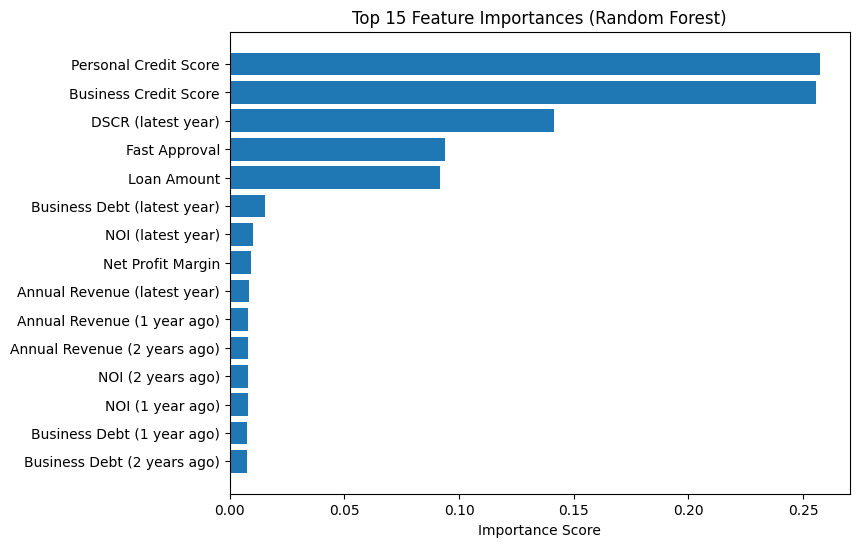

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Use Random Forest from the ensemble
rf_model = voting_clf.named_estimators_['rf']
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Plot top 15 important features
indices = np.argsort(importances)[-15:]
plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.title('Top 15 Feature Importances (Random Forest)')
plt.xlabel('Importance Score')
plt.show()


### Punishing

In [13]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Drop leaky features
leaky_cols = ['Loan Amount', 'Fast Approval', 'Business Credit Score', 'Personal Credit Score']
X_clean = X.drop(columns=leaky_cols)

# Resplit
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_clean, y, stratify=y, test_size=0.2, random_state=42
)

# SMOTE oversampling
smote = SMOTE(random_state=42)
X_resampled_new, y_resampled_new = smote.fit_resample(X_train_new, y_train_new)

# Class-weighted models
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
gb = GradientBoostingClassifier(random_state=42)  # no native class weight
xgb = XGBClassifier(
    scale_pos_weight=(len(y_train_new) / sum(y_train_new)),
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
lgbm = LGBMClassifier(class_weight='balanced', random_state=42)
cat = CatBoostClassifier(auto_class_weights='Balanced', verbose=0, random_state=42)

# Voting ensemble
voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('gb', gb), ('xgb', xgb), ('lgbm', lgbm), ('cat', cat)],
    voting='soft',
    n_jobs=-1
)

# Train the ensemble
voting_clf.fit(X_resampled_new, y_resampled_new)

# Predict with threshold tuning
y_probs = voting_clf.predict_proba(X_test_new)[:, 1]
y_pred_thresh = (y_probs >= 0.3).astype(int)

# Evaluate
print("Classification Report with threshold 0.3:\n")
print(classification_report(y_test_new, y_pred_thresh))


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Classification Report with threshold 0.3:

              precision    recall  f1-score   support

           0       0.97      0.87      0.91     19272
           1       0.06      0.22      0.09       728

    accuracy                           0.84     20000
   macro avg       0.51      0.54      0.50     20000
weighted avg       0.93      0.84      0.88     20000



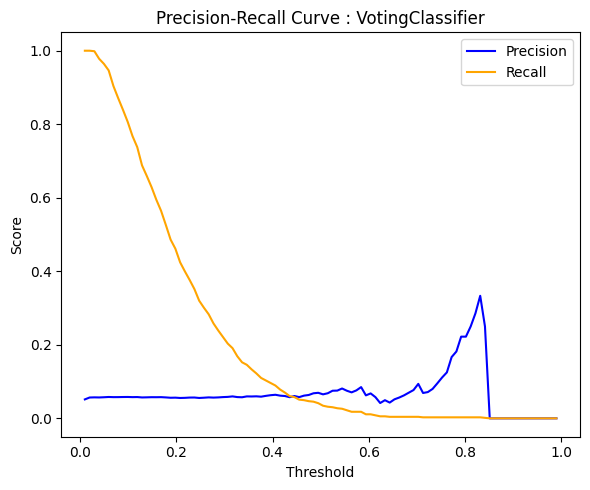

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score

# Generate probabilities from the voting classifier
y_probs = voting_clf.predict_proba(X_test_new)[:, 1]

# Create arrays to hold precision and recall values for each threshold
thresholds = np.linspace(0.01, 0.99, 100)
precisions = []
recalls = []

for t in thresholds:
    preds = (y_probs >= t).astype(int)
    precisions.append(precision_score(y_test_new, preds, zero_division=0))
    recalls.append(recall_score(y_test_new, preds, zero_division=0))

# Plot precision and recall curves
plt.figure(figsize=(6, 5))
plt.plot(thresholds, precisions, label="Precision", color="blue")
plt.plot(thresholds, recalls, label="Recall", color="orange")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall Curve : VotingClassifier")
plt.legend()
plt.tight_layout()
plt.show()


🧠 Precision-Recall Curve Interpretation
Recall starts high at low thresholds, then quickly falls:

✅ At threshold ≈ 0.01, recall ≈ 1.0 (you’re predicting most Express loans)

❌ But at that point, precision is very low — so you're catching a lot, but many are false positives.

Precision stays low until threshold > 0.7, then increases:

❌ You're only confident (precision improves) when threshold is very high — but recall becomes near zero.

📉 In other words: The model has poor confidence in identifying Express loans, even with SMOTE and class weighting.

📉 What This Suggests
Your minority class (Express Loan) is still underrepresented in feature patterns, even after SMOTE.

The model has learned too much from the majority class and struggles to assign high probabilities to Express samples.

You may be operating in a space where there's no threshold that gives you both good precision and recall.